In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sep
import math
import keras
import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import random

import aplpy
from astroquery.sdss import SDSS

Using TensorFlow backend.


IMAGE FROM CTMO

In [2]:
hdu_ctmo = fits.open("/home/kasiawardega/Documents/thesis/kw_data/ctmo-stack-pgc21577.fit")

In [3]:
data_ctmo = hdu_ctmo[0].data

In [4]:
hdu_ctmo[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4096 / Axis length                                    
NAXIS2  =                 4096 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-02-08T22:38:58' / Date FITS file was generated                  
IRAF-TLM= '2020-02-08T22:38:34' / Time of last modification                     
OBJECT  = 'pgc21577'           / Name of the object observed                    
DATE-OBS= '2020-02-08T04:30:14' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   60.000000000000000 /Exposure time in seconds                        
EXPOSURE=   60.0000000000000

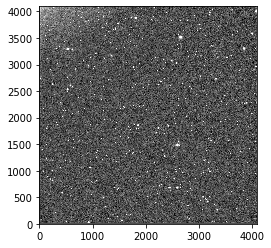

In [5]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_ctmo)

fig = plt.imshow(data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.savefig('pictures/imagectmo_pgc1.png')
#plt.imsave('image_ctmo_pgc21577.png', data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

In [5]:
np.save('data_ctmo.npy', data_ctmo)

IMAGE FROM SDSS

In [5]:
from astroquery.skyview import SkyView
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
import astropy.units as u

#frame_coord = SkyCoord(ra=center_ra * u.deg, dec=center_dec * u.deg).icrs
fov_radius = 80 * u.arcmin
pos = SkyCoord(ra='115.509266924', dec='42.6163652645', unit='deg')

hdu_sdss = SkyView.get_images(position=pos, pixels=2000,
                         survey='SDSSg', radius=fov_radius)[0]

In [6]:
hdu_sdss[0].header

SIMPLE  =                    T / Written by SkyView Mon Feb 17 21:30:26 EST 2020
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                 2000 / Width of image                                 
NAXIS2  =                 2000 / Height of image                                
CRVAL1  =              115.509 / Reference longitude                            
CRVAL2  =              42.6164 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =               1000.5 / X reference pixel                              
CRPIX2  =               1000

In [8]:
data_sdss = hdu_sdss[0].data

#np.save('data_sdss.npy', data_sdss)

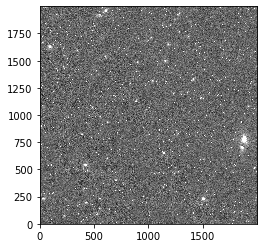

In [9]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_sdss)
fig = plt.imshow(data_sdss, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.savefig('pictures/imagesdss_pgc1.png')
#plt.imsave('image_sdss.png', data_sdss, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

ALIGNING IMAGES

In [10]:
from reproject import reproject_interp
data_sdss_fitted, footprint = reproject_interp(hdu_sdss[0], hdu_ctmo[0].header)

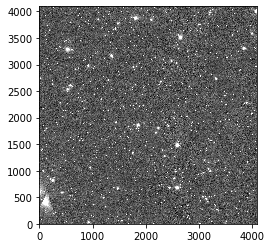

In [11]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_sdss_fitted)
fig = plt.imshow(data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.savefig('pictures/imagesdss_pgc1aling.png')
#plt.imsave('image_sdss_fitted.png', data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

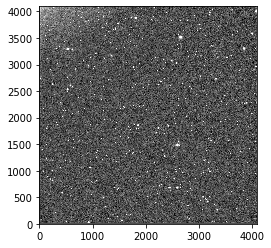

In [13]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_ctmo)
plt.imshow(data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
#plt.imsave('image_sdss_fitted.png', data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

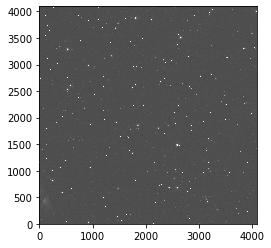

In [38]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_ctmo)
plt.imshow(data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
#plt.imsave('image_sdss_scale_ctmo.png', data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

In [72]:
def show_field(field1,field2):

    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = interval.get_limits(data_ctmo)

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1, vmin = _min, vmax = _max,cmap='gray')
    ax.autoscale(False)
    ax2 = fig.add_subplot(2, 1, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2, vmin = _min, vmax = _max,cmap='gray')
    ax2.autoscale(False)
    plt.show()

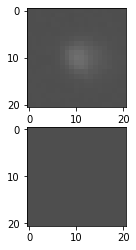

In [77]:
show_field(merge_dataset[400,:,:,0], merge_dataset[400,:,:,1])

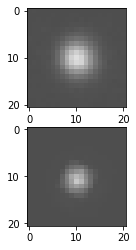

In [82]:
show_field(merge_dataset[0,:,:,0], merge_dataset[0,:,:,1])

OBJECT DETECTION - CTMO IMAGE 

In [5]:
bkg = sep.Background(data_ctmo.astype("f8"),bw=128, bh=128, fw=3, fh=3)
sigma = bkg.globalrms

data_ctmo = data_ctmo.byteswap().newbyteorder()

objects = sep.extract(data_ctmo, 3*sigma, err=bkg.globalrms)

In [6]:
len(objects)

417

In [12]:
objects['tnpix']

array([ 84, 306,  89, 117,  29,  79,  50,  38, 163,  22,  10,  51,  13,
        30,  31,  20,  22,  22,  66,  56,  57,  84,  28,  26, 203,  70,
        36, 114,  11, 129,  15,  58, 151,  44,  16,  58,  29, 100,   7,
        56,  21, 172,  20,  32,  61,  21,   7, 189, 163,  53, 164,  42,
        70,  72,  98, 253,  60,  36,  14, 121,  48,  37,  67,  37,  15,
        93,  24, 186,  26, 106,  15, 249, 358, 113,  17,  32,  47,  15,
        54,  87,   5,  21, 284,  28, 209,  39,  13,  46, 107,  64,   7,
        27,  35,  97,  11,  79,  64, 131,  18, 175,  49, 224,  22,  54,
        21, 106, 178,  56,  91,  16,  24,   9,  11, 173, 178,  26,  28,
        16,  58,  91, 105,  85, 140,  10,  68, 114,  64,  81,  67,  18,
        28,  41,   5, 146,  60,  60,   9,  47,  72,  56,  81,  20,  66,
        42, 118,  13,  17,  46,  74,  12, 134, 101,   5,  25,   5, 551,
        22,  49, 111,   8,  57,  36,  46,  26,  17,  10,  98,  30,  81,
        95,  13,  29,  25,  85,  34, 181,  11,  18,  27,  58, 11

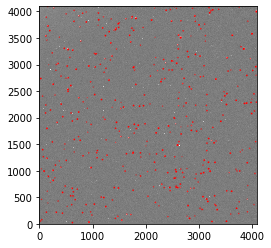

In [10]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_ctmo), np.std(data_ctmo)
im = ax.imshow(data_ctmo, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [17]:
np.round(objects['x']).shape

(417,)

In [18]:
objects_coord = []

for i in range (0,len(objects)):
    objects_coord.append([objects['x'][i], objects['y'][i]])
    
objects_coord = np.array(objects_coord)

In [19]:
objects_coord.shape[0]

417

    CREATING DATASETS

In [20]:
def cut_object(im, x,y,l):
    x = int(round(x))
    y = int(round(y))
    
    return im[y-l:y+l+1, x-l:x+l+1]

In [21]:
def creating_dataset (im, coord):
    
    images = []
    for i in range (0,coord.shape[0]):
        
        if (coord[i][0] < im.shape[1]-21 and coord[i][1] < im.shape[0]-21):
            images.append(cut_object(im, coord[i][0], coord[i][1],10))
            #images[i,:,:] = cut_object(im, objects['x'][i], objects['y'][i],10)
            
    images = np.array(images)
    return images

In [22]:
def creating_transient (im, coord):
    
    images  = []    
    
    for i in range (0,coord.shape[0]):
        x = random.randint(21,im.shape[1]-21)
        y = random.randint(21,im.shape[0]-21)
                
        while not checkAwayFromStars(x, np.round(objects_coord[:,0])):
             x = random.randint(21,im.shape[1]-21)
        
        while not checkAwayFromStars(y, np.round(objects_coord[:,0])):
             y = random.randint(21,im.shape[1]-21)
        #while x in np.round(coord[:,0]):
            #x = random.randint(21,im.shape[1]-21)
            
        #while y in np.round(coord[:,1]):
            #y = random.randint(21,im.shape[0]-21)
                   
        if (coord[i][0] < im.shape[1]-21 and coord[i][1] < im.shape[0]-21):
            images.append(cut_object(im, x, y,10))
            
    images = np.array(images)
    return images    


In [23]:
def checkAwayFromStars(point, stars, minDist = 10):
    "Check that point is at at least minDist from any other position in stars iterable."
    for p in stars:
        if np.linalg.norm(point - p) < minDist:
            return False
    return True


In [24]:
data_ctmo_scaled = data_ctmo/60
# 60s - exposure time

In [25]:
transient_sample = creating_transient(data_sdss_fitted, objects_coord)

/home/kasiawardega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


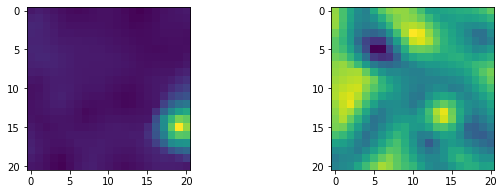

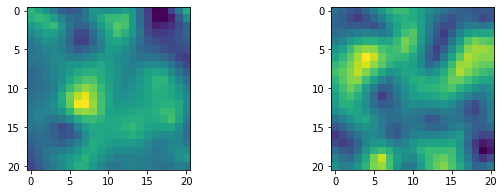

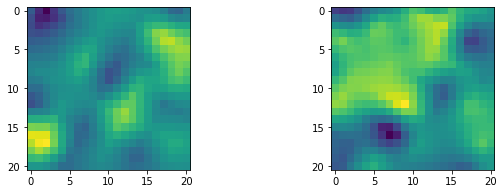

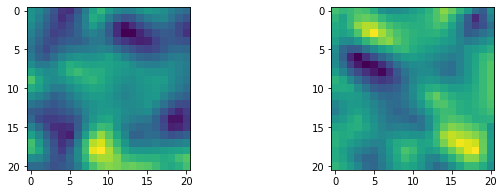

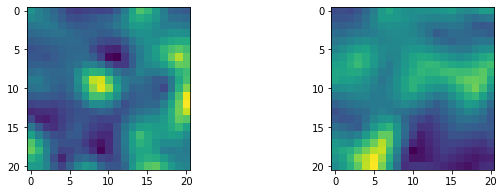

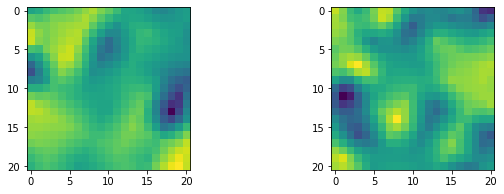

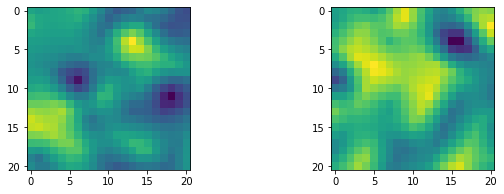

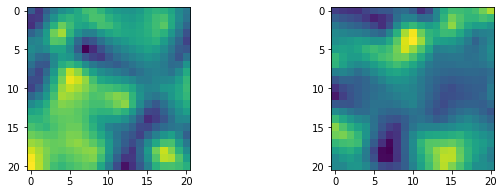

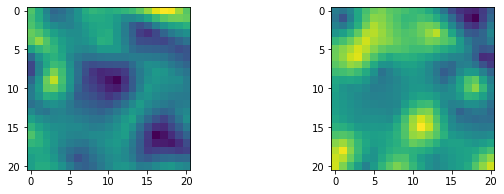

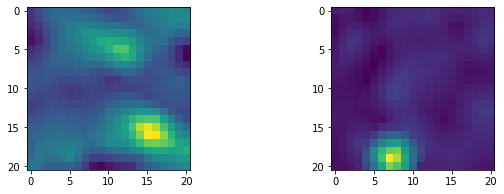

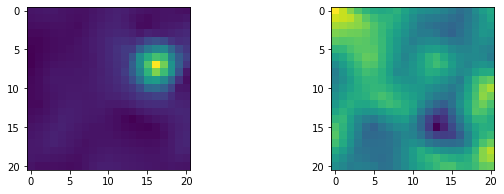

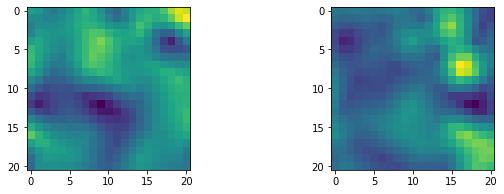

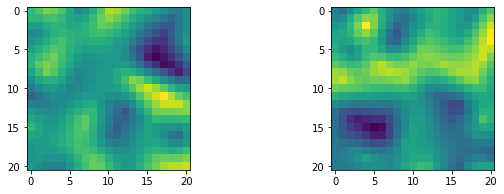

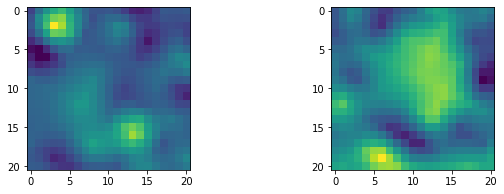

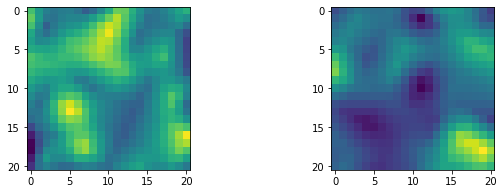

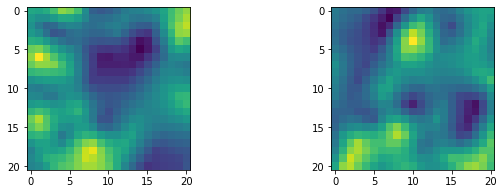

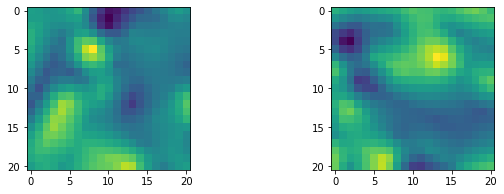

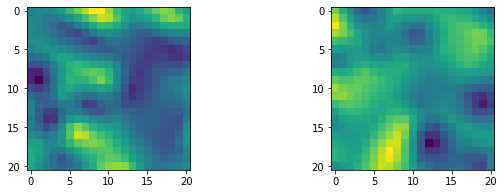

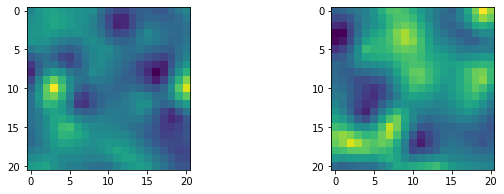

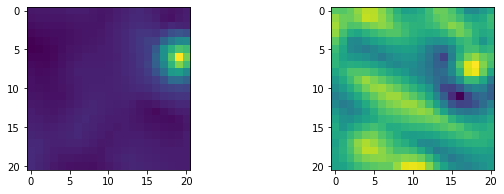

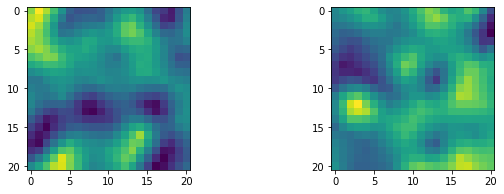

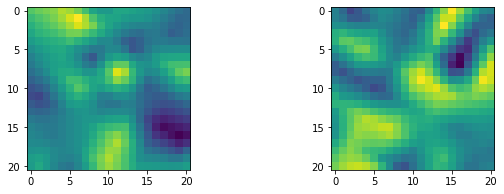

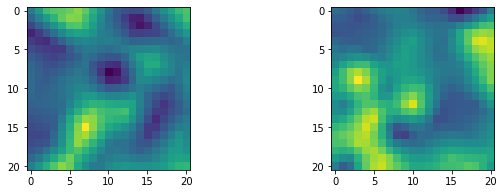

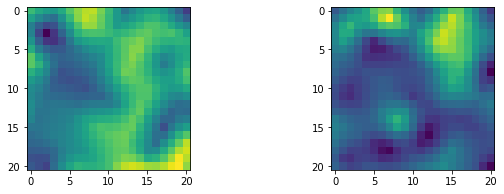

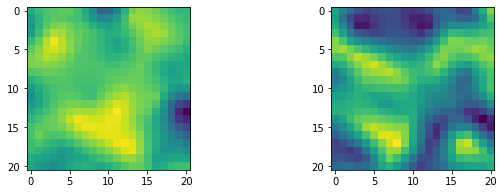

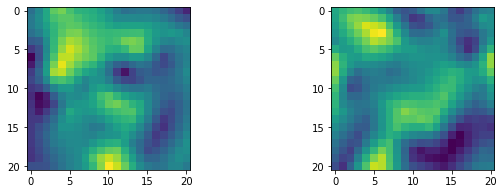

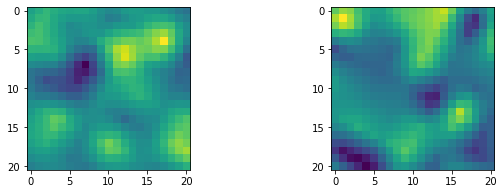

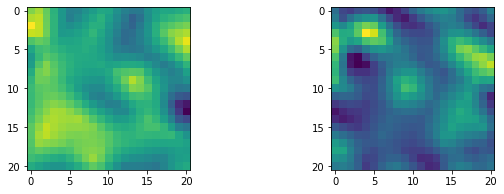

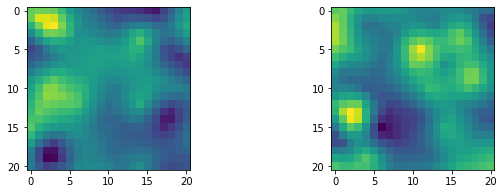

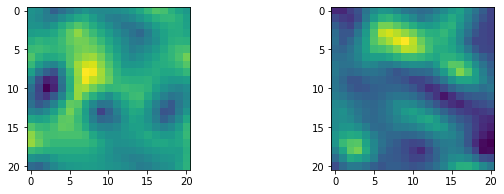

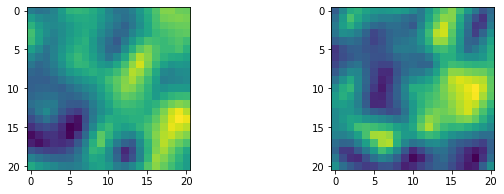

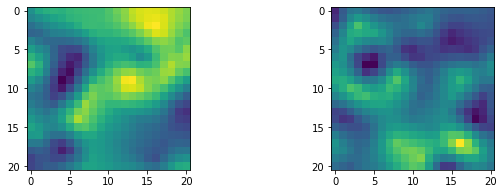

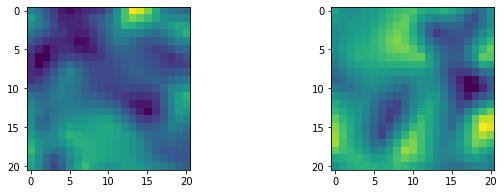

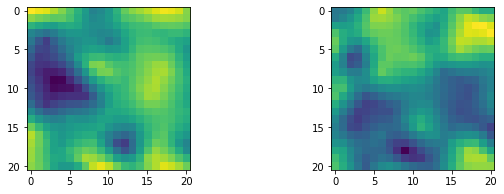

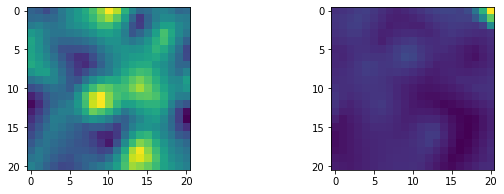

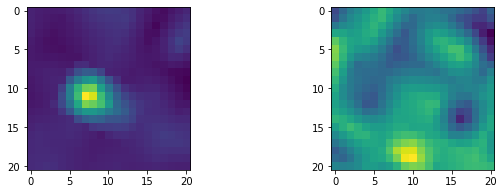

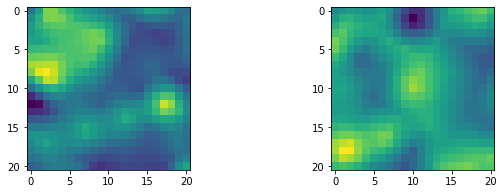

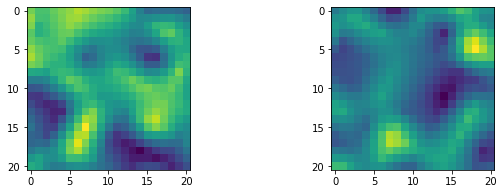

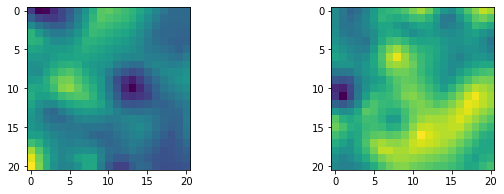

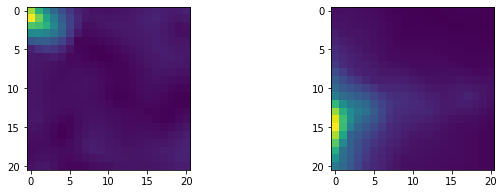

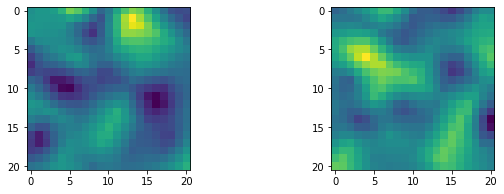

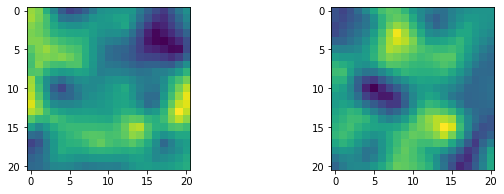

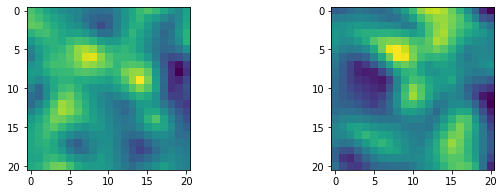

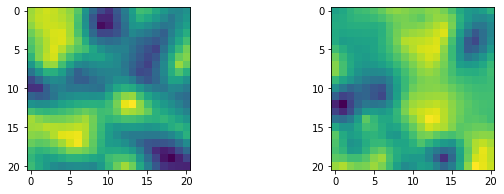

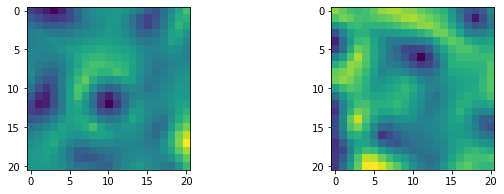

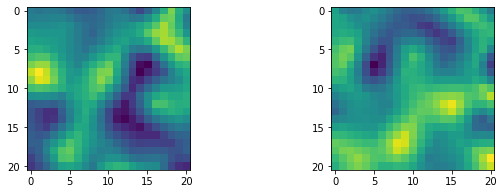

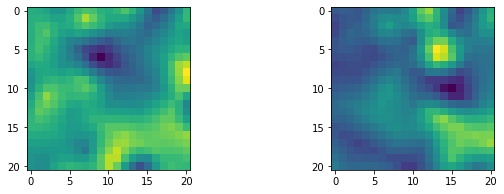

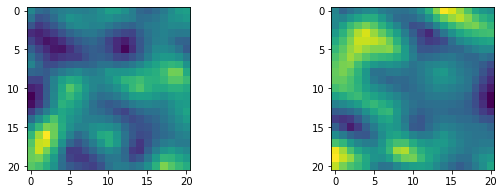

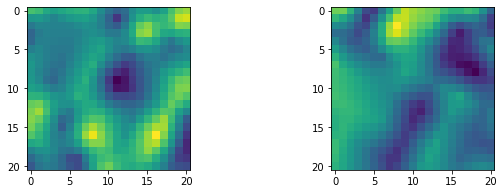

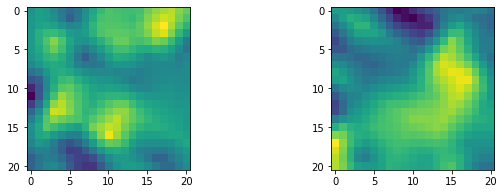

In [36]:
#examples of background

for i in range(0,100,2):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)    
    ax.imshow(transient_sample[i,:,:])
    ax2.imshow(transient_sample[i+1,:,:])


In [26]:
dataset_ctmo = creating_dataset(data_ctmo, objects_coord)

In [27]:
dataset_ctmo_scaled = creating_dataset(data_ctmo_scaled, objects_coord)

In [28]:
dataset_ctmo_scaled.shape

(410, 21, 21)

In [29]:
dataset_sdss = creating_dataset(data_sdss_fitted, objects_coord)

In [30]:
dataset_sdss.shape

(410, 21, 21)

In [31]:
dataset_ic4559_nontran = np.zeros((dataset_ctmo_scaled.shape[0],21,21,2))
dataset_ic4559_tran = np.ones((dataset_ctmo_scaled.shape[0],21,21,2))

In [32]:
labels_ic4559_nontran = np.zeros(dataset_ctmo_scaled.shape[0])
labels_ic4559_tran = np.ones(dataset_ctmo_scaled.shape[0])

In [33]:
#dataset_ic4559_nontran[:,:,:,0] = dataset_ctmo_scaled
dataset_ic4559_nontran[:,:,:,0] = dataset_ctmo
dataset_ic4559_nontran[:,:,:,1] = dataset_sdss

dataset_ic4559_tran[:,:,:,0] = dataset_ctmo_scaled
dataset_ic4559_tran[:,:,:,1] = transient_sample


/home/kasiawardega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


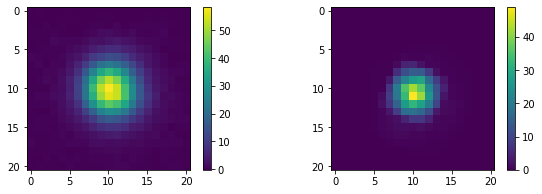

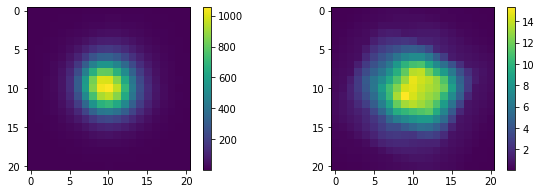

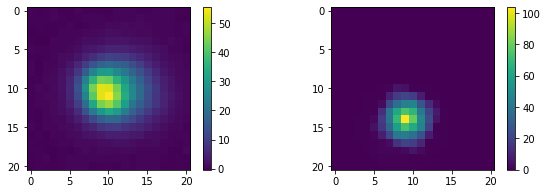

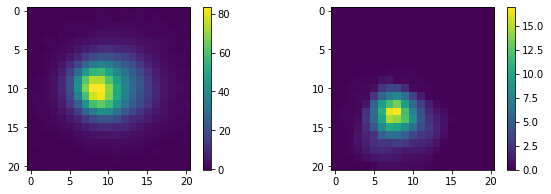

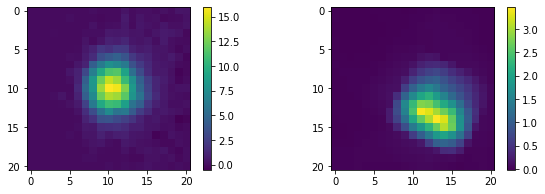

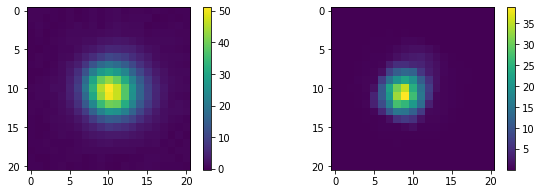

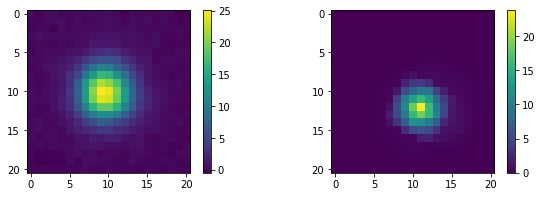

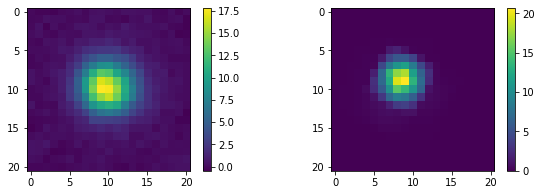

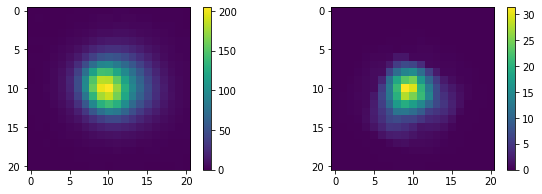

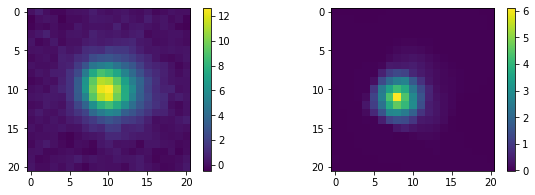

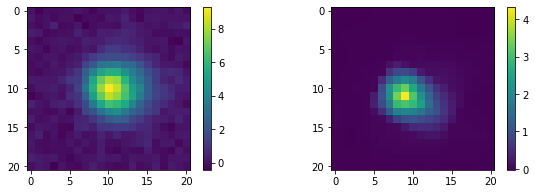

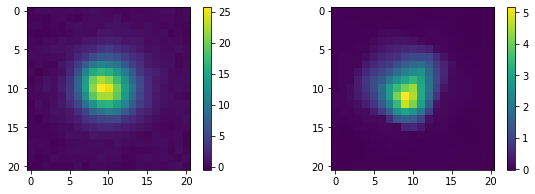

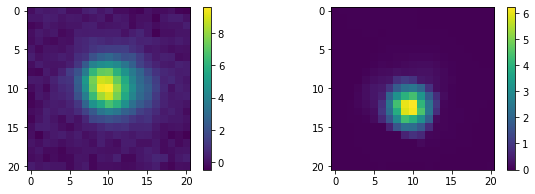

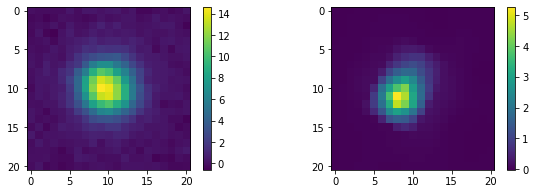

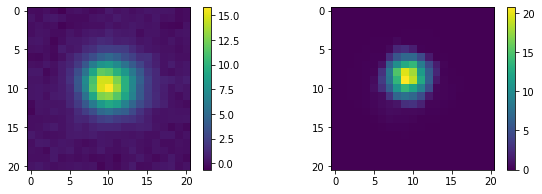

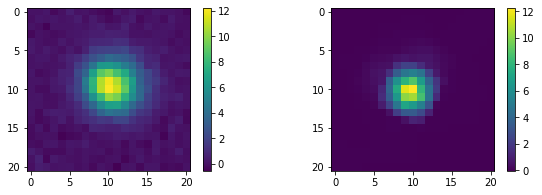

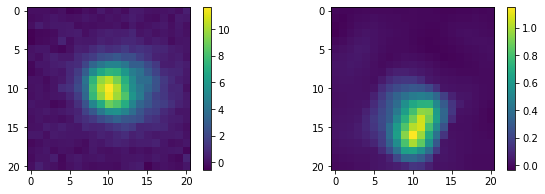

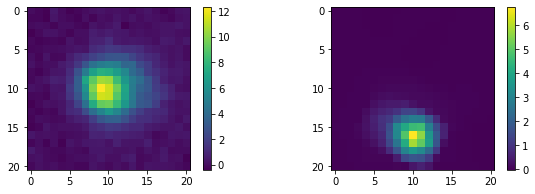

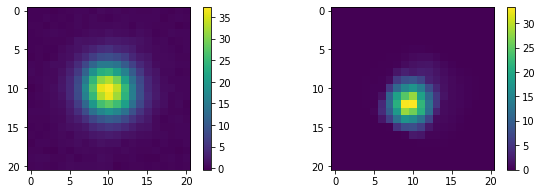

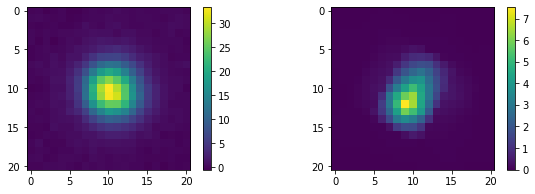

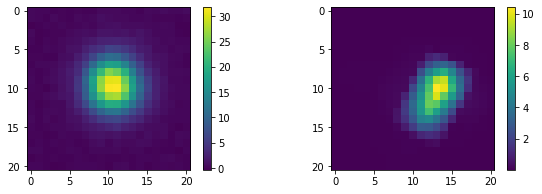

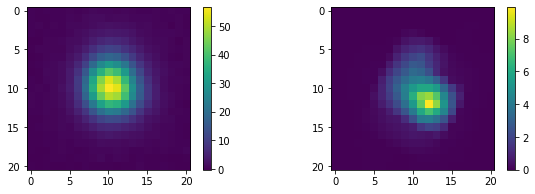

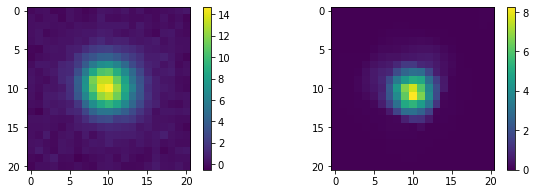

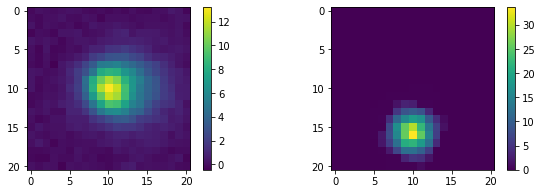

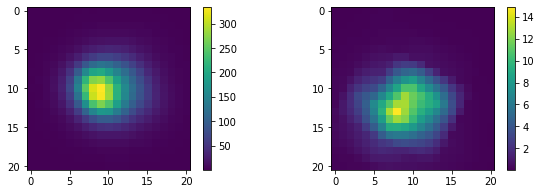

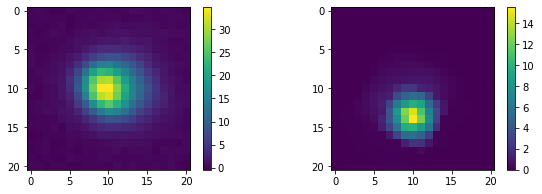

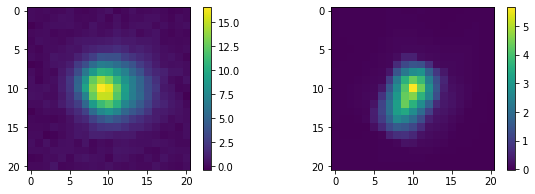

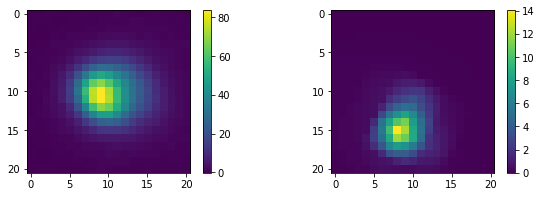

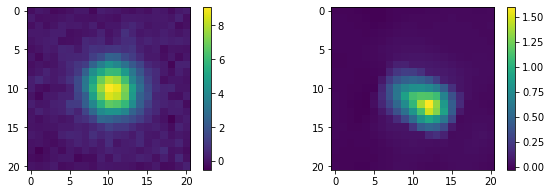

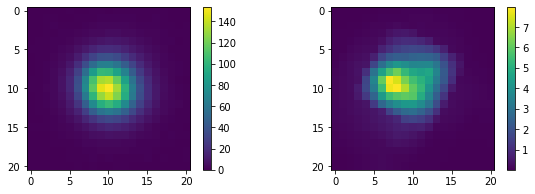

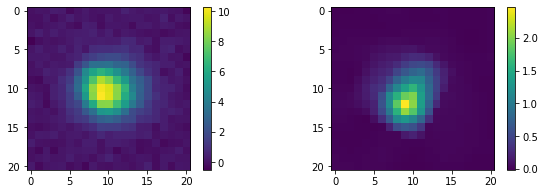

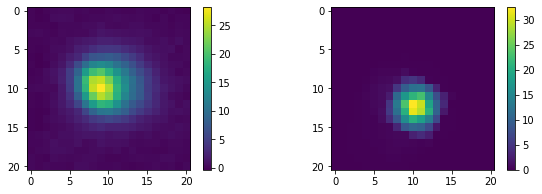

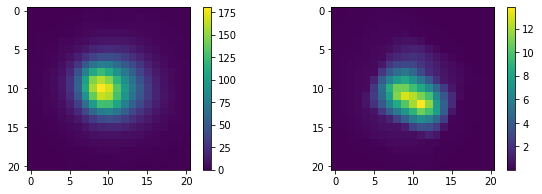

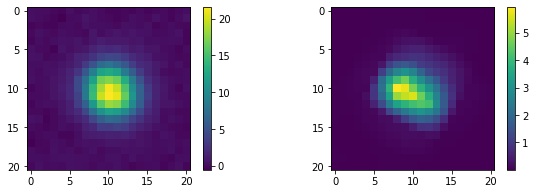

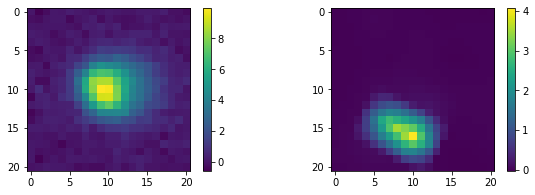

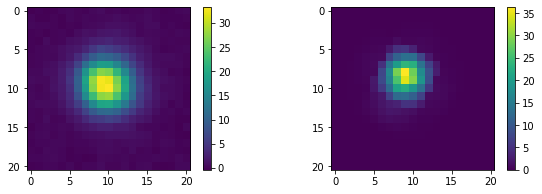

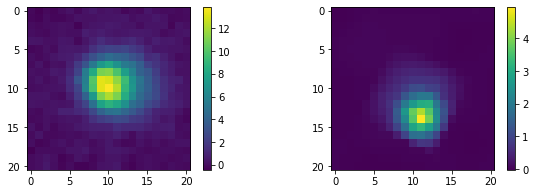

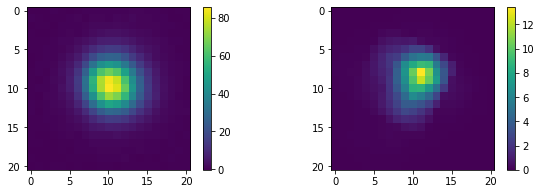

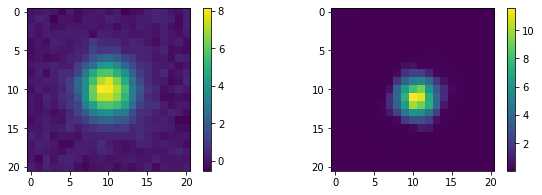

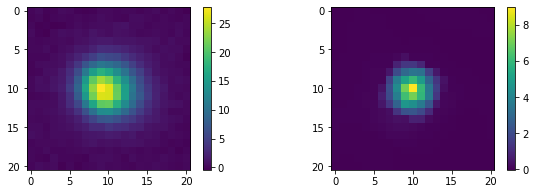

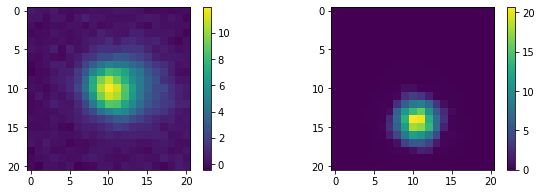

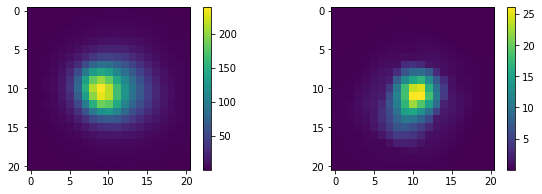

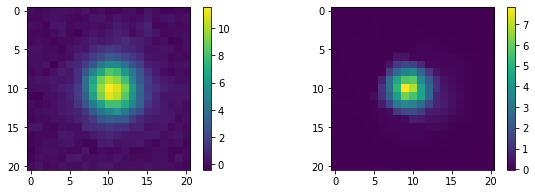

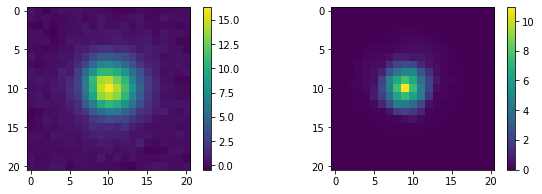

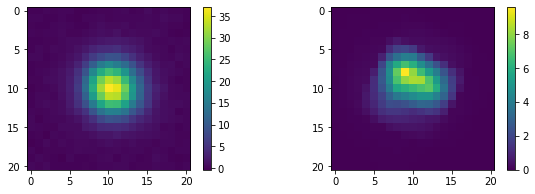

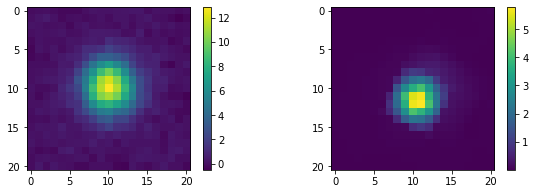

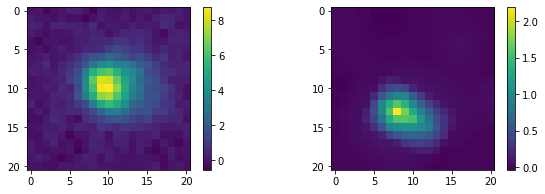

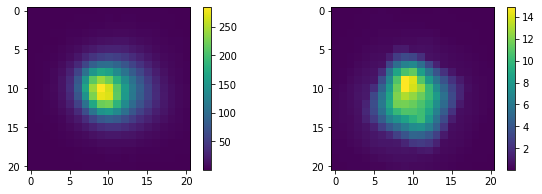

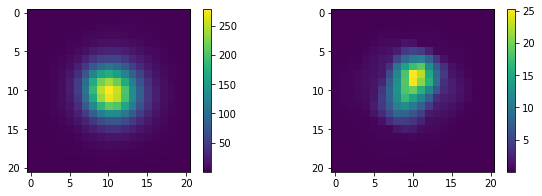

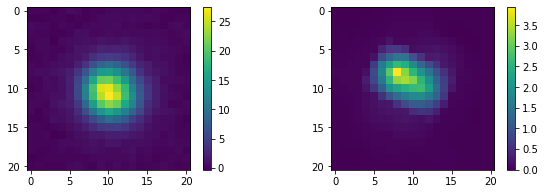

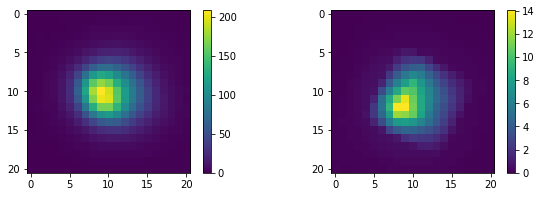

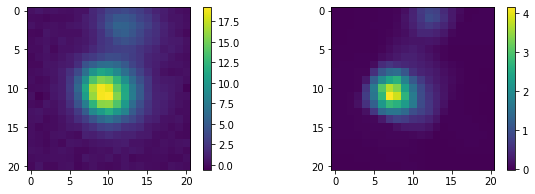

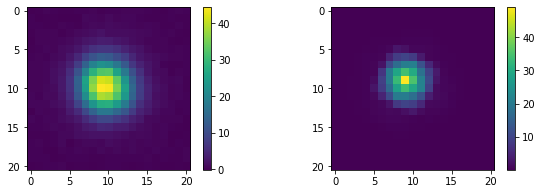

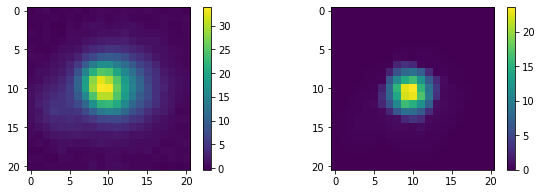

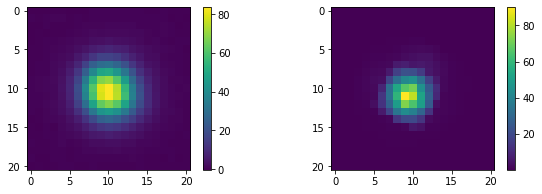

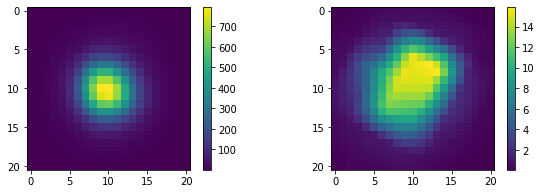

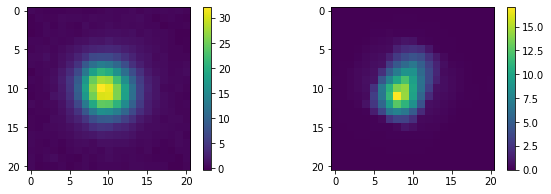

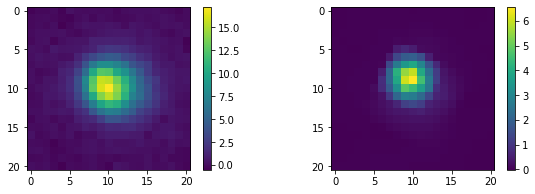

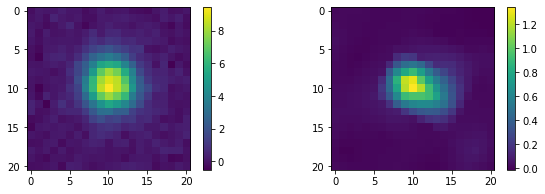

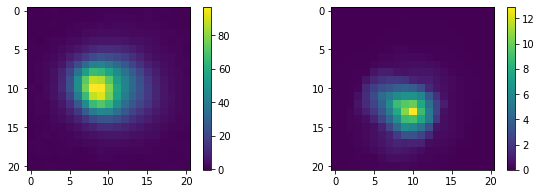

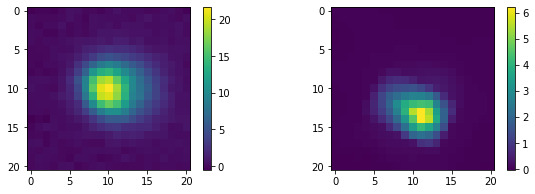

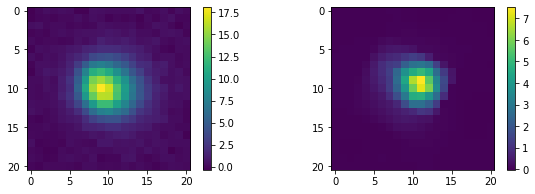

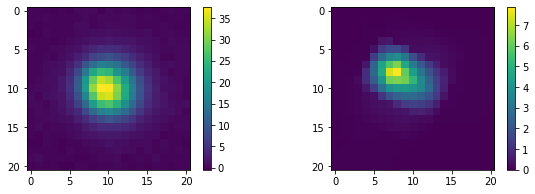

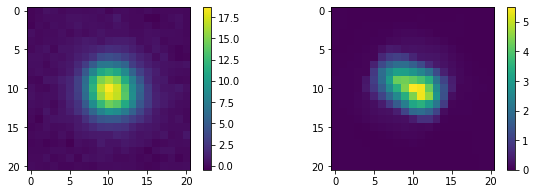

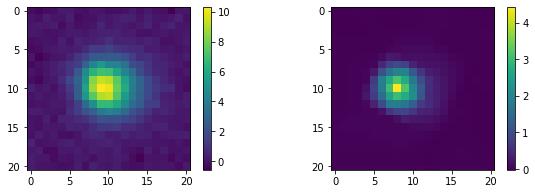

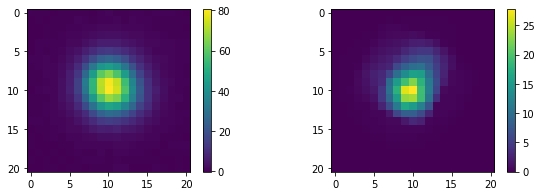

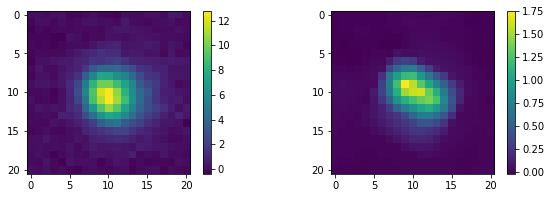

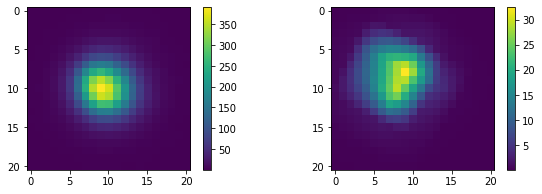

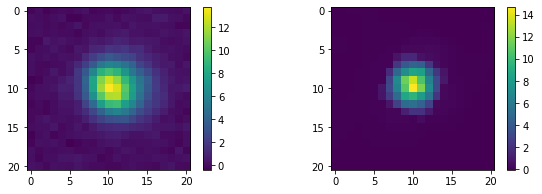

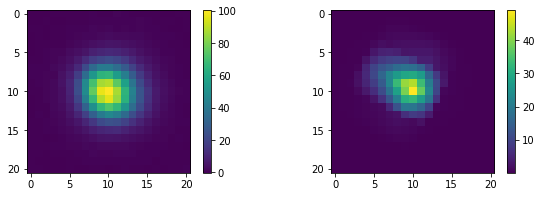

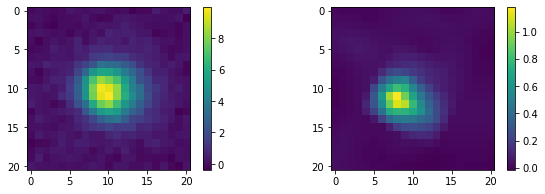

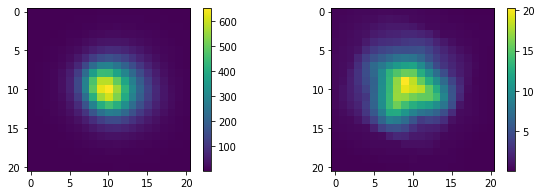

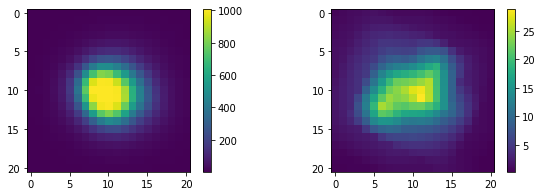

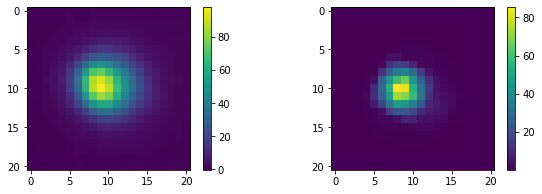

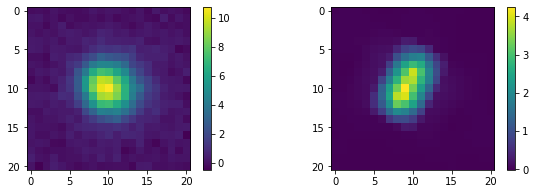

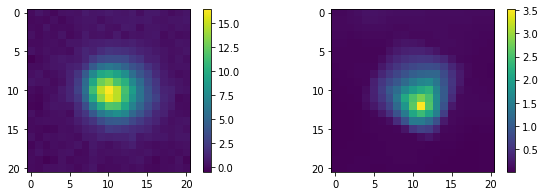

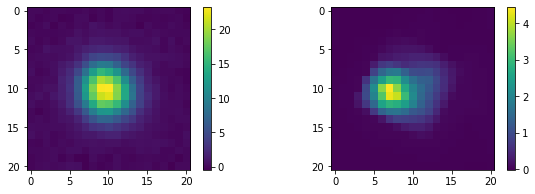

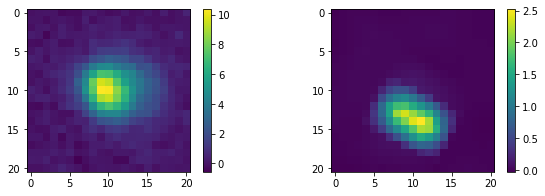

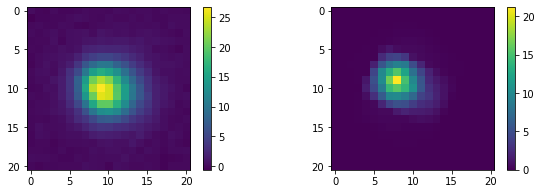

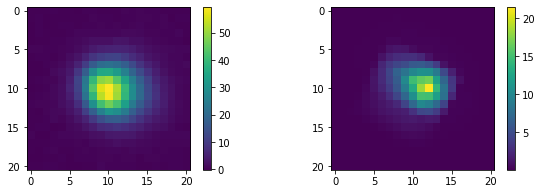

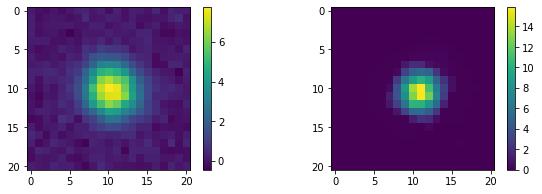

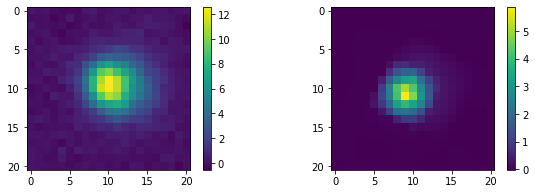

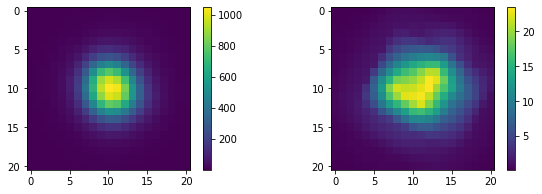

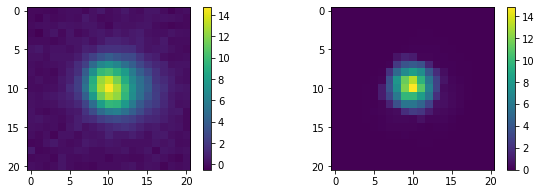

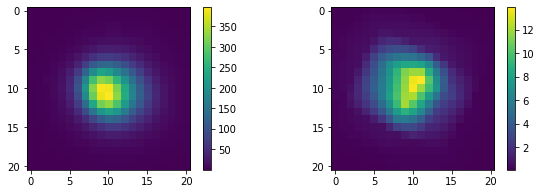

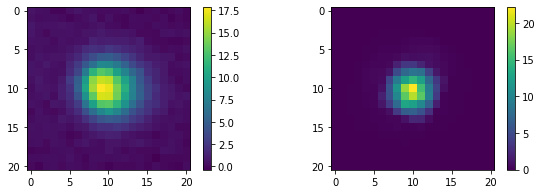

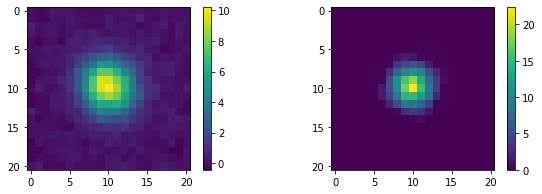

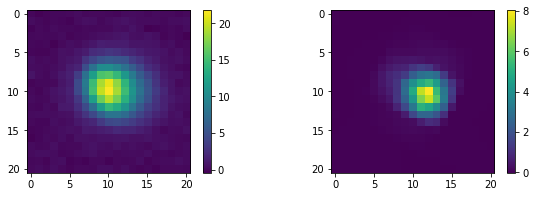

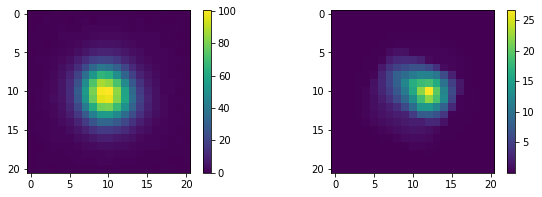

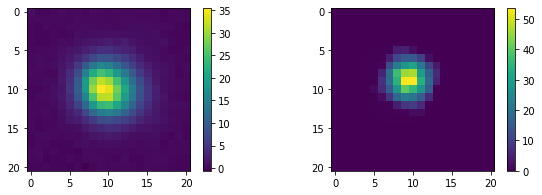

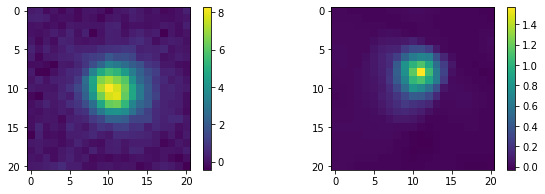

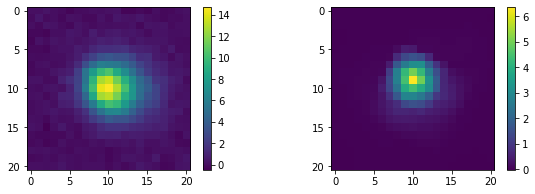

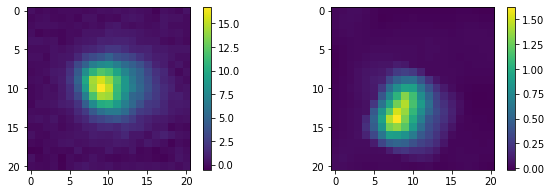

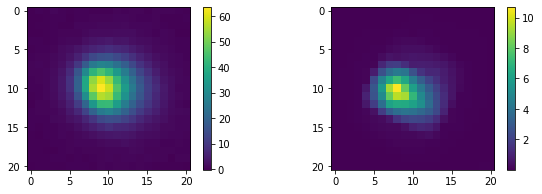

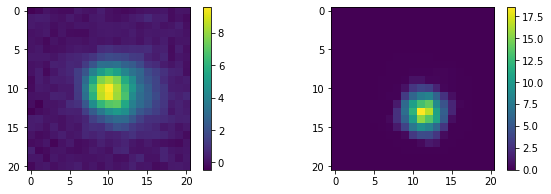

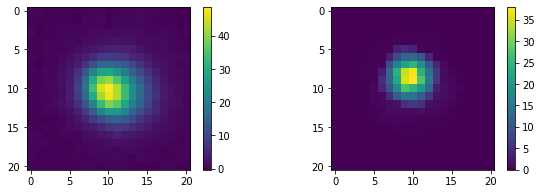

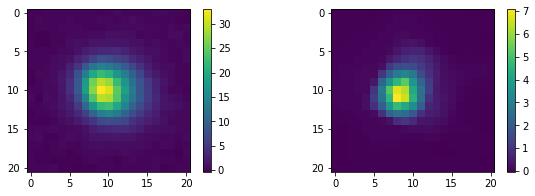

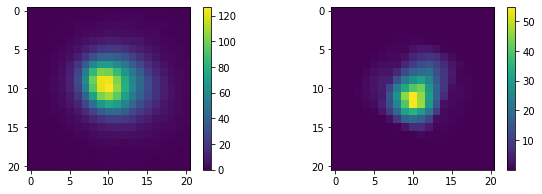

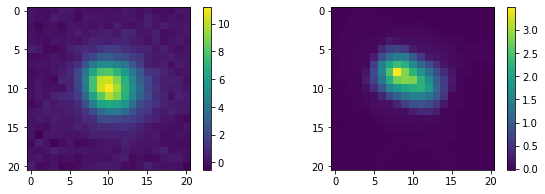

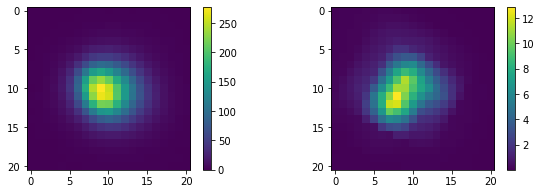

In [42]:
#NONTRANSIENT SAMPLES

for i in range(100):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)    
    fig_1 = ax.imshow(dataset_ic4559_nontran[i,:,:,0])
    fig_2 = ax2.imshow(dataset_ic4559_nontran[i,:,:,1])
    f.colorbar(fig_1, ax=ax)
    f.colorbar(fig_2, ax=ax2)

/home/kasiawardega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


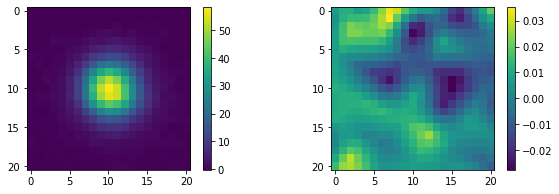

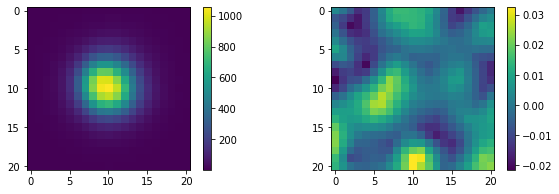

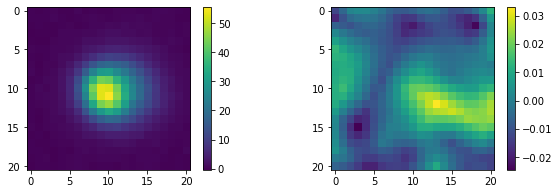

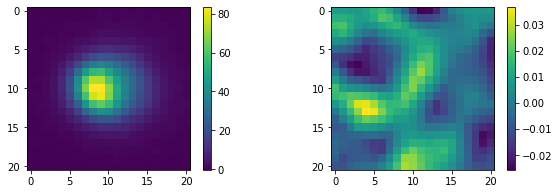

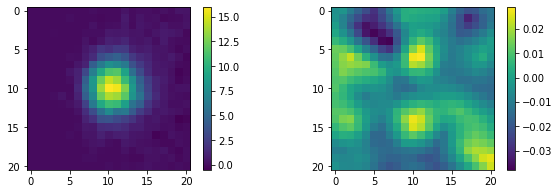

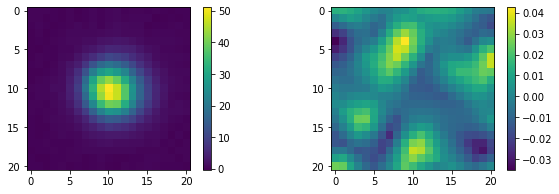

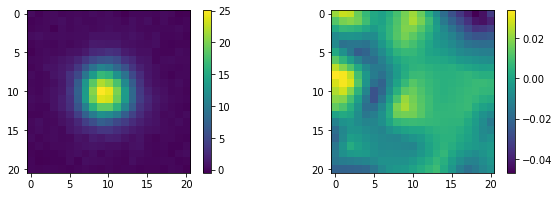

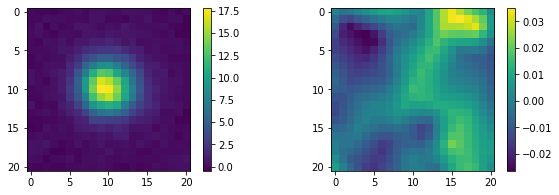

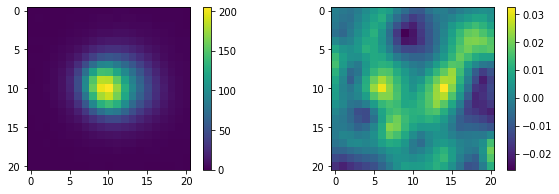

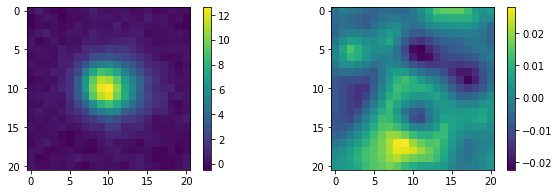

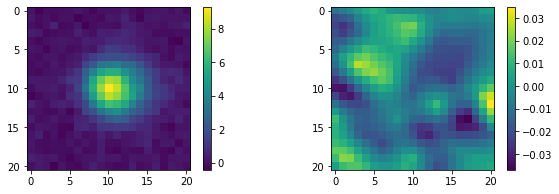

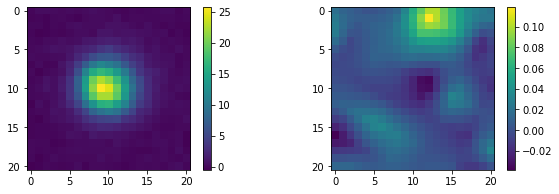

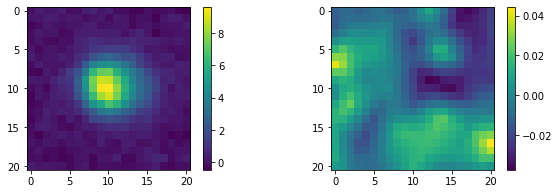

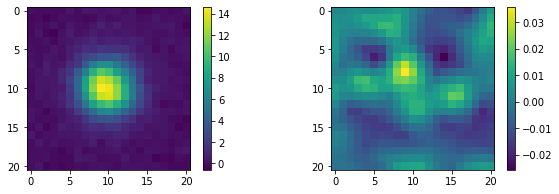

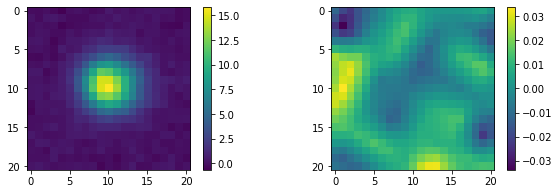

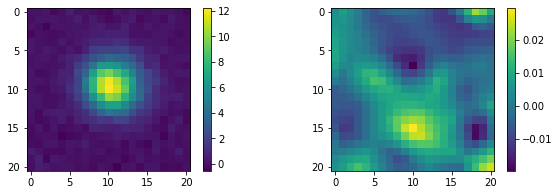

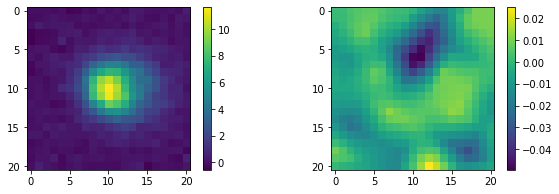

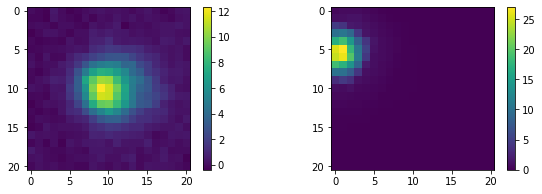

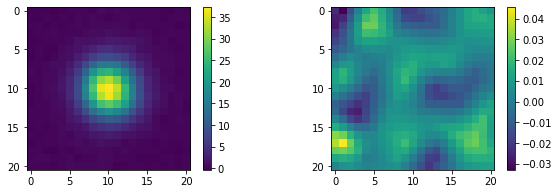

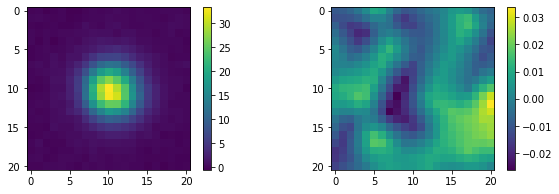

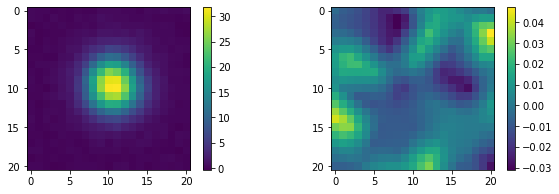

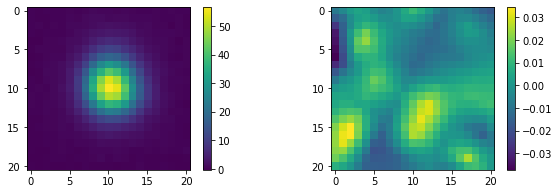

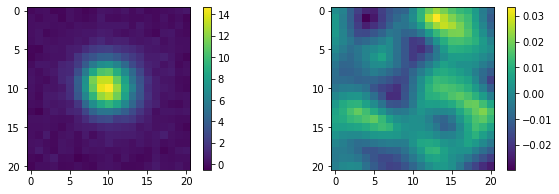

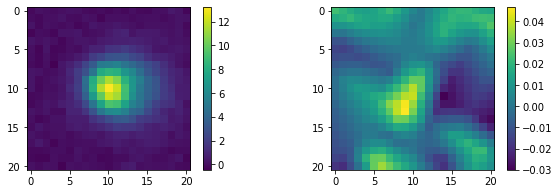

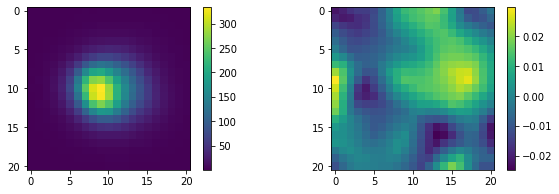

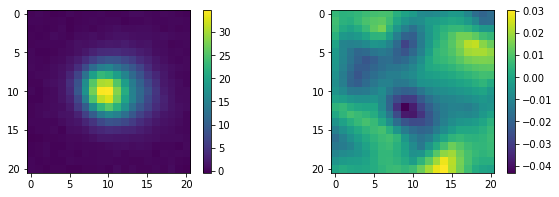

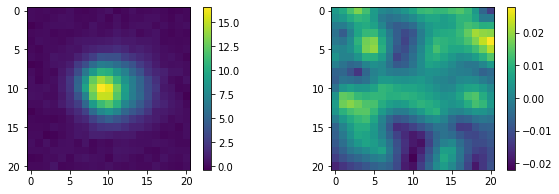

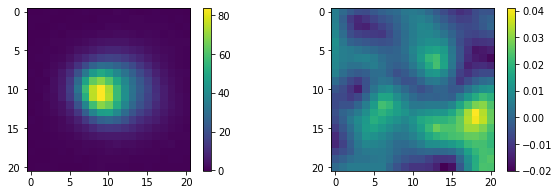

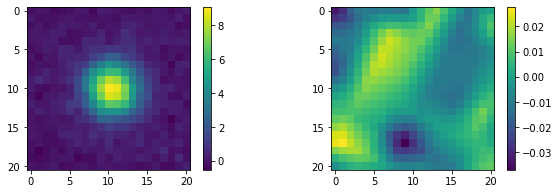

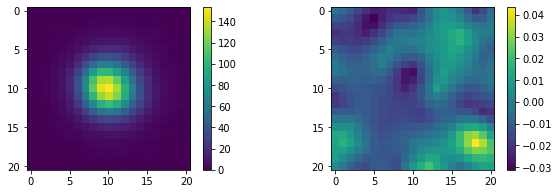

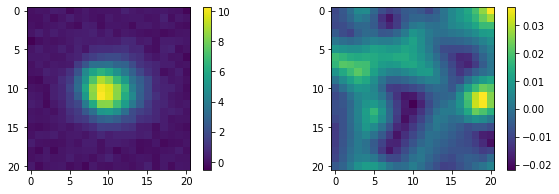

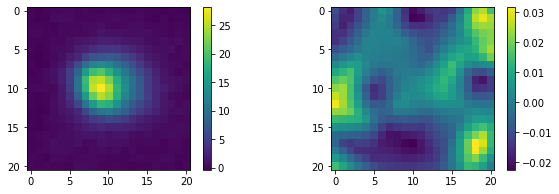

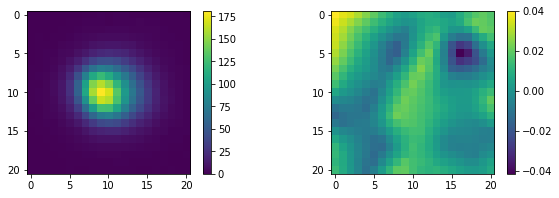

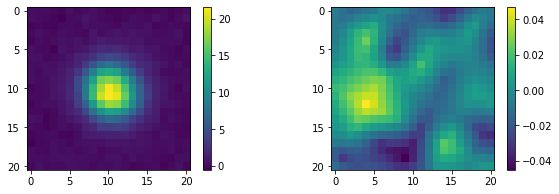

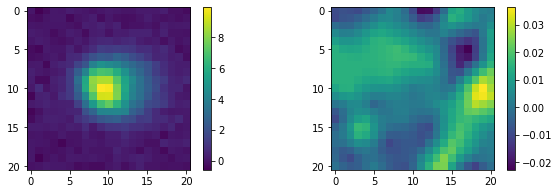

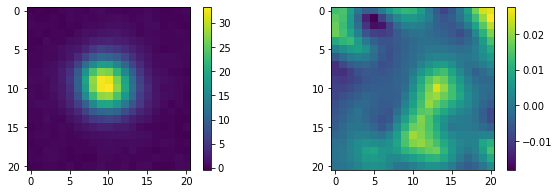

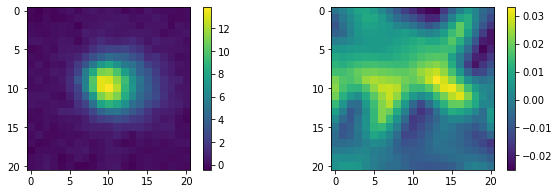

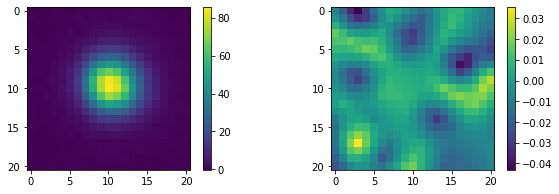

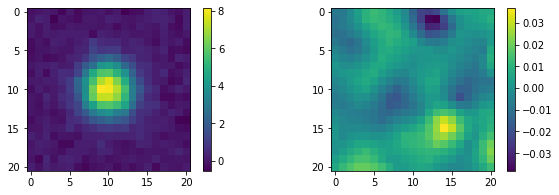

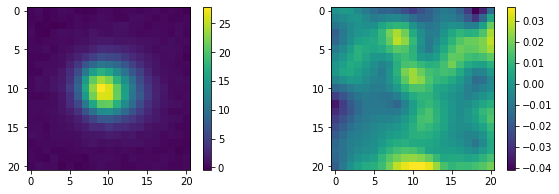

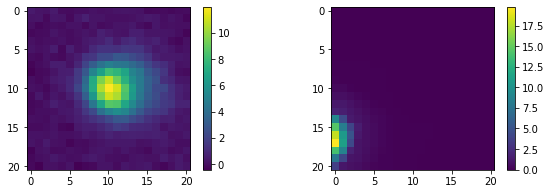

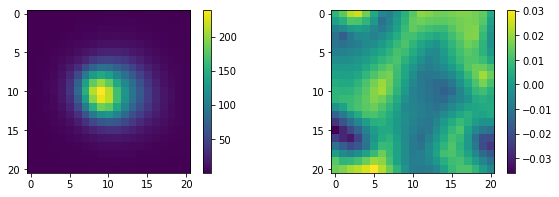

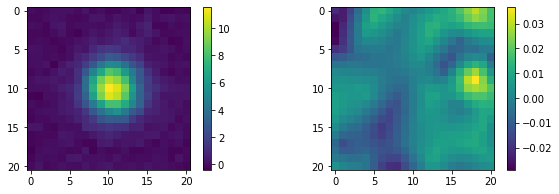

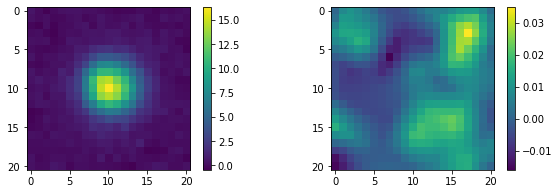

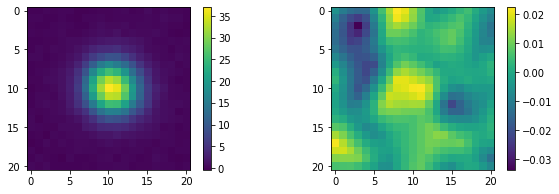

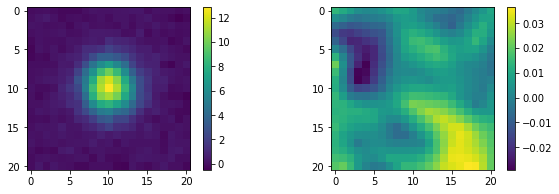

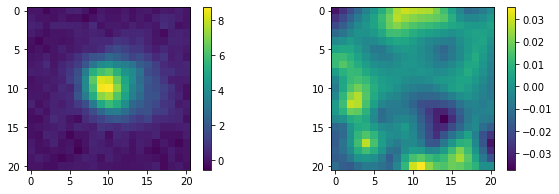

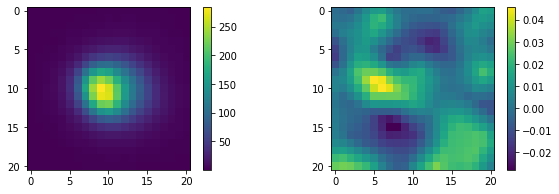

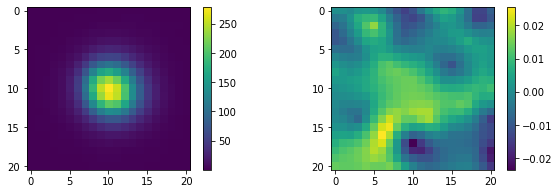

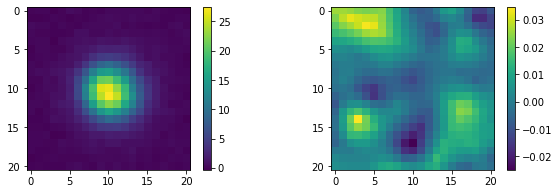

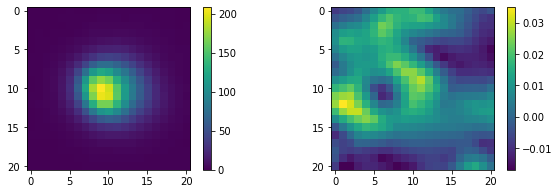

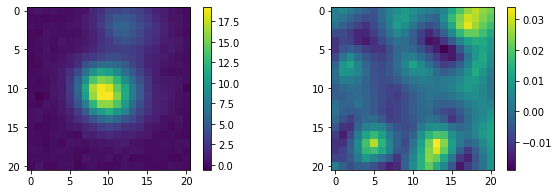

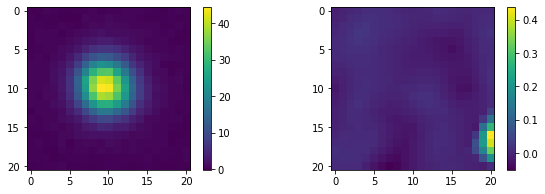

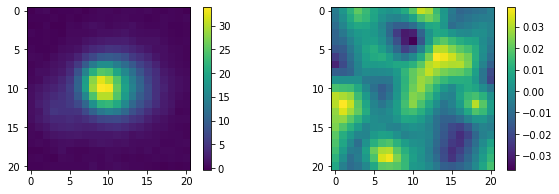

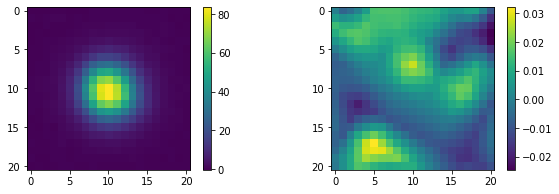

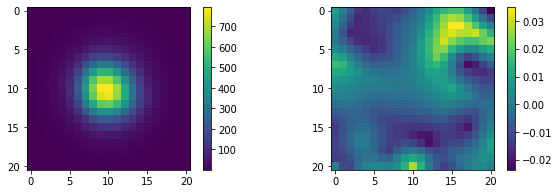

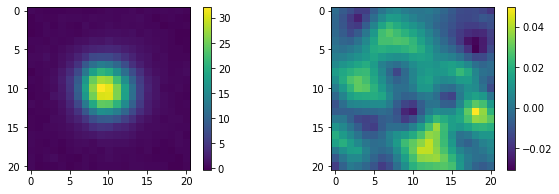

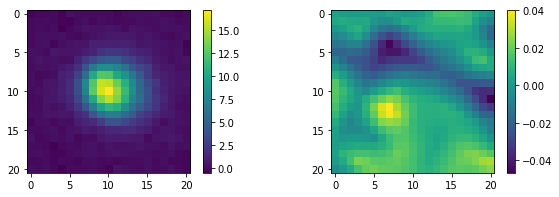

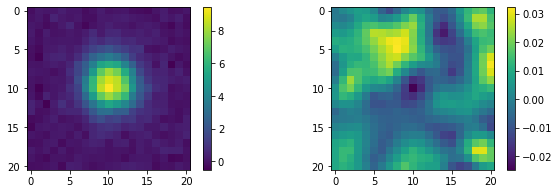

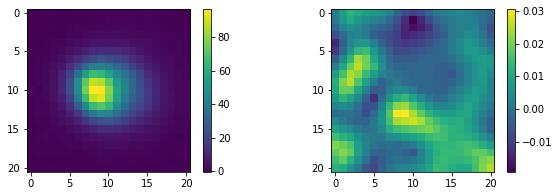

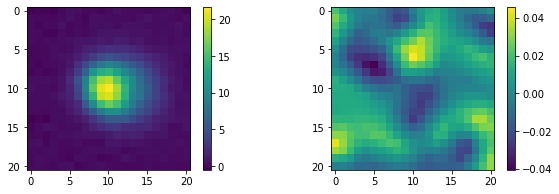

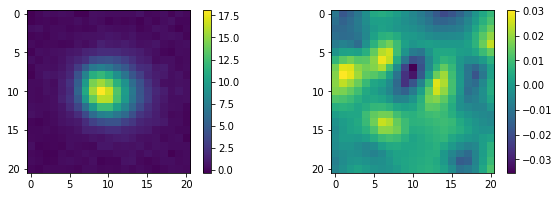

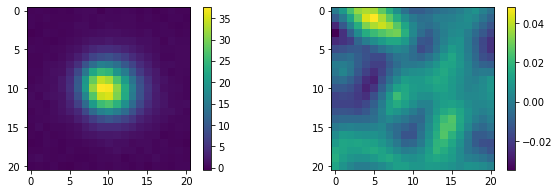

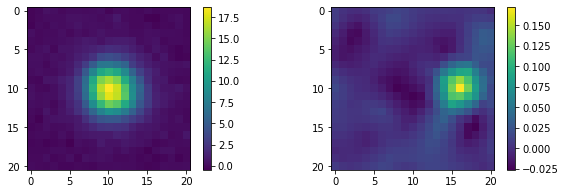

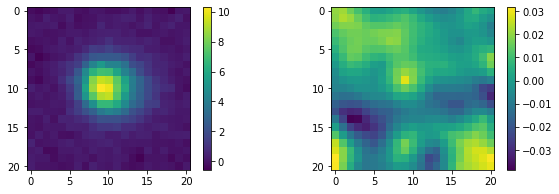

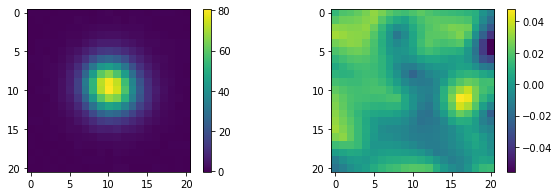

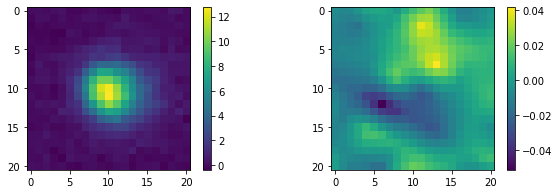

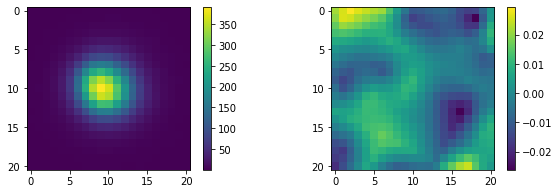

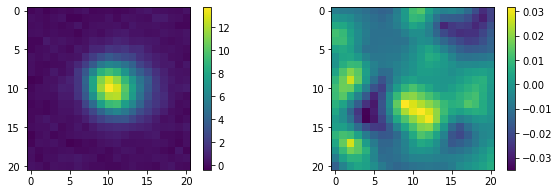

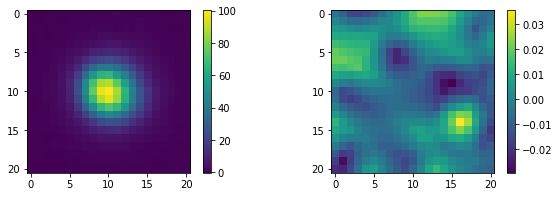

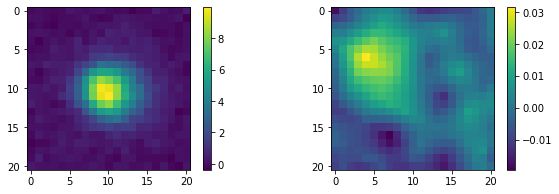

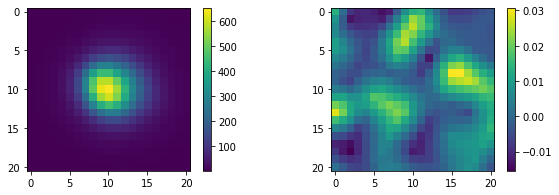

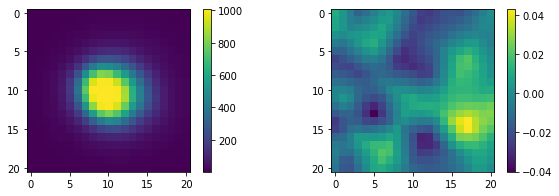

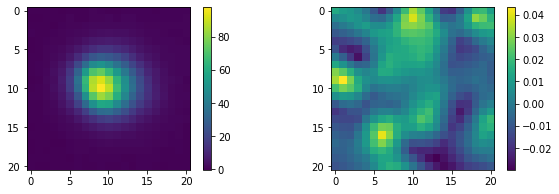

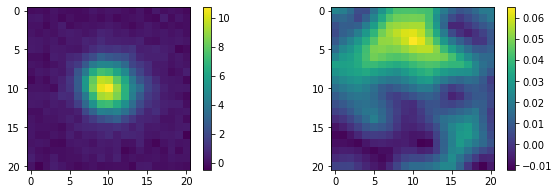

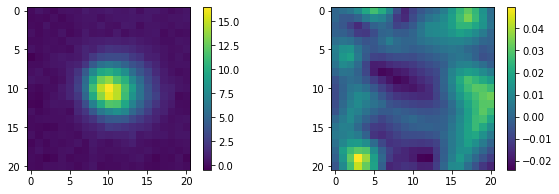

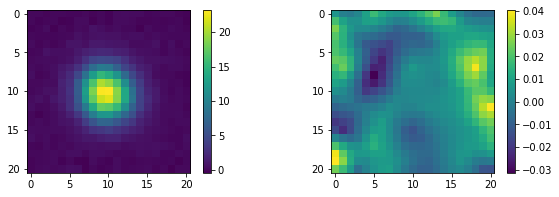

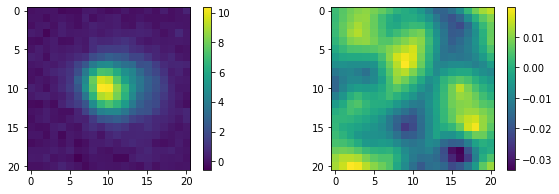

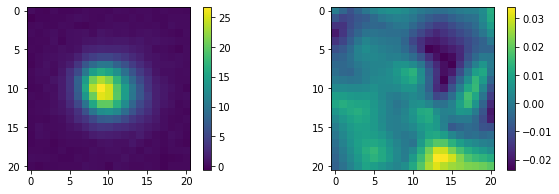

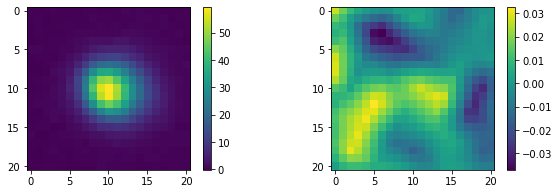

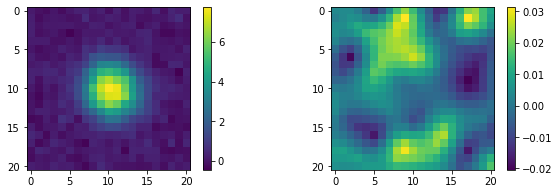

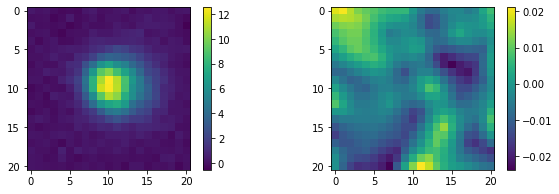

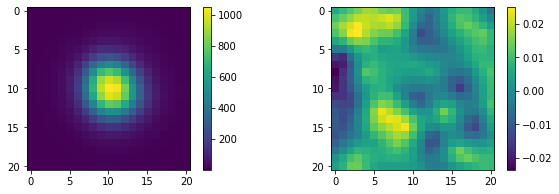

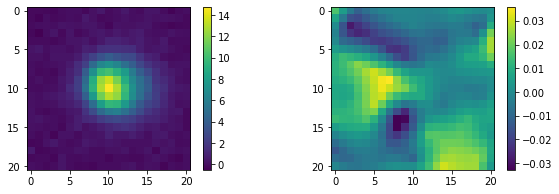

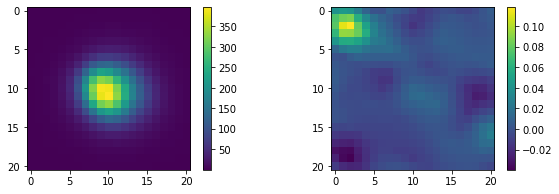

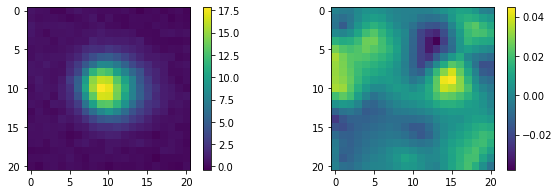

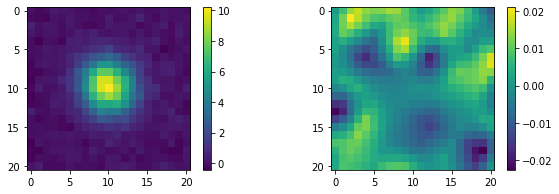

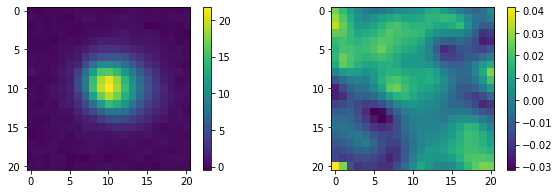

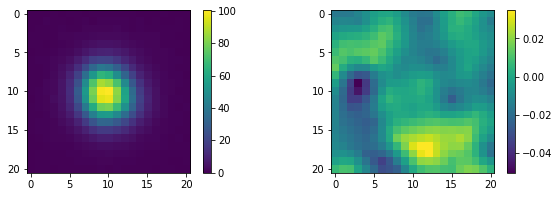

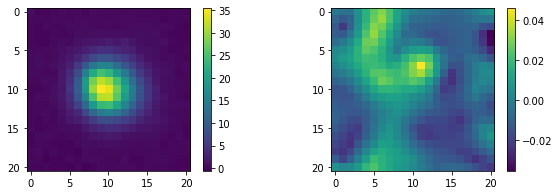

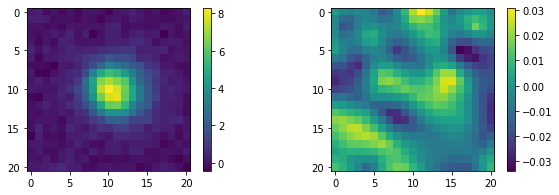

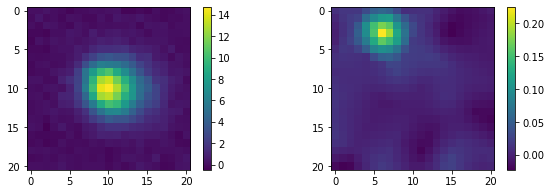

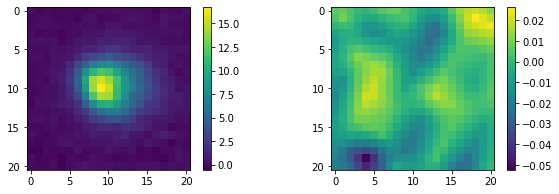

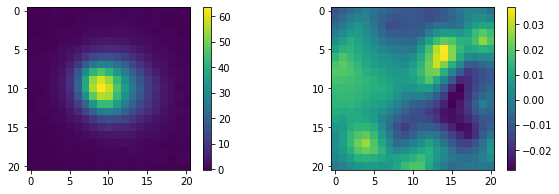

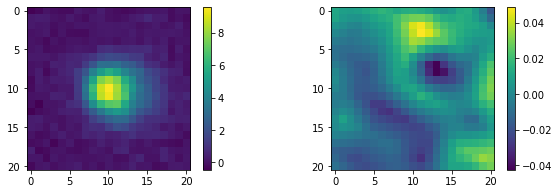

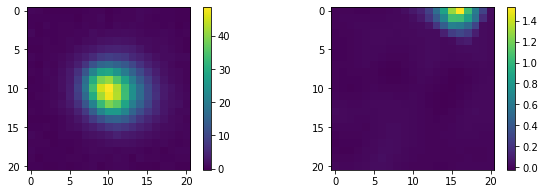

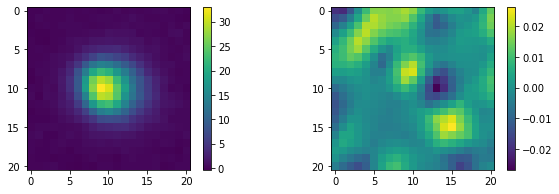

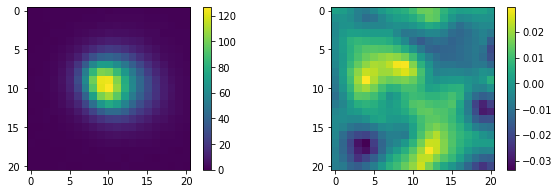

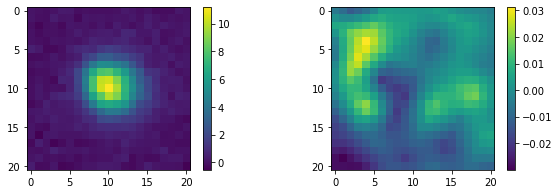

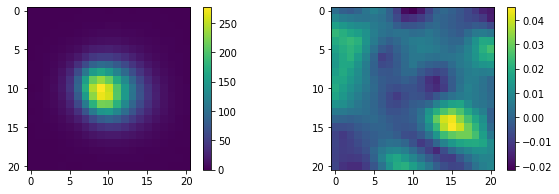

In [43]:
#TRANSIENT SAMPLES

for i in range(100):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)    
    fig_1 = ax.imshow(dataset_ic4559_tran[i,:,:,0])
    fig_2 = ax2.imshow(dataset_ic4559_tran[i,:,:,1])
    
    f.colorbar(fig_1, ax=ax)
    f.colorbar(fig_2, ax=ax2)

In [34]:
#MERGING TRANSIENT AND NONTRANSIENT SAMPLES

def merging_datasets(nontr, tr):
    
           
    dataset = np.append(nontr, tr, axis=0)
    
    x = dataset.shape[0]
    y = int(x/2)
    labels = np.zeros(x)
    labels[y:x] = 1

    return dataset, labels



In [35]:
merge_dataset, labels = merging_datasets(dataset_ic4559_nontran,dataset_ic4559_tran)

In [36]:
merge_dataset.shape

(820, 21, 21, 2)

In [37]:
np.save('datasets/galaxy_pgc21577_images.npy', merge_dataset)

In [44]:
np.save('datasets/galaxy_pgc21577_images_scaled.npy', merge_dataset)
np.save('datasets/galaxy_pgc21577_labels_scaled.npy', labels)